In [1]:
import cPickle, glob, h5py, os, string, matplotlib
#matplotlib.use('Agg')
import numpy as np
import matplotlib.pyplot as plt
from imp import reload

from oc_ica import gabor_fit, plotting, analysis, styles

/home/jesse/anaconda3/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder = '/home/jesse/Development/results/oc_ica/nat_images_mixtures-64_sources-128'
files = sorted(glob.glob(os.path.join(folder, '*.h5')))
models = [f.split('.')[0].split('-')[-1] for f in files]
n_mixtures = int(folder.split('-')[-2].split('_')[0])
n_sources = int(folder.split('-')[-1].split('_')[0])
print(models)

['2', '4', 'COULOMB', 'COULOMB_F', 'RANDOM', 'RANDOM_F', 'SM']


In [3]:
ws = np.full((len(models), 50, n_sources, n_mixtures), np.nan)
for ii, fname in enumerate(files):
    with h5py.File(fname) as f:
        ws[ii] = np.squeeze(f['W_fits'].value)

In [12]:
params = plotting.get_Gabor_params(ws[:, 0])
with open(os.path.basename(folder)+'.pkl', 'w') as f:
    cPickle.dump(params, f)

In [5]:
with open(os.path.basename(folder)+'.pkl', 'r') as f:
    params = cPickle.load(f)

In [24]:
rng = np.random.RandomState(2017)
ws_null = ws[:, 0].copy()

for ii in range(ws_null.shape[0]):
    for jj in range(ws_null.shape[2]):
        order = rng.permutation(ws_null.shape[1])
        ws_null[ii, :, jj] = ws_null[ii, :, jj][order]
    ws_null[ii] = ws_null[ii]/np.linalg.norm(ws_null[ii], axis=1, keepdims=True)
params_null = plotting.get_Gabor_params(ws_null)

In [88]:
n_mixtures = 64

In [13]:
ws.shape

(7, 50, 128, 64)

In [6]:
reload(plotting)
n = 0
idxs = [0, 1, 3]
modelsp = [models[ii] for ii in idxs]
f = plt.figure(figsize=((5./3)*len(modelsp), 7))
height_by_width = float(8 * 8 + 7 * 2) / float(16 * 8 + 7 * 15)
width = 1. - .225
height = height_by_width * width
print(height_by_width, width, height)
ax = f.add_axes([.1125, .725, width, height])

plotting.plot_bases(ws[4, 0], (f, ax))
for ii, m in zip(idxs, modelsp):
    labelx = True
    if n//3 == 0:
        labely = True
    else:
        labely = False
    pos = (4, len(modelsp), 3+n//len(modelsp)+1)
    plotting.plot_GaborFit_xy(params[ii][1], int(np.sqrt(n_mixtures)), m, f=f, pos=pos,
                              labelx=labelx, labely=labely)
    print pos
    n += 1
    pos = (4, len(modelsp), 3+n//len(modelsp)+4)
    plotting.plot_GaborFit_polar(params[ii][1], m, f=f, pos=pos,
                                 labelx=labelx, labely=False)
    print pos
    n += 1
    pos = (4, len(modelsp), 3+n//len(modelsp)+7)
    plotting.plot_GaborFit_envelope(params[ii][1], m, f=f, pos=pos,
                                    labelx=labelx, labely=labely)
    print pos
    n += 1
x = .05
f.text(x, .975, 'A', fontsize=styles.letter_fontsize)
f.text(x, .675, 'B', fontsize=styles.letter_fontsize)
f.text(x, .45, 'C', fontsize=styles.letter_fontsize)
f.text(x, .285, 'D', fontsize=styles.letter_fontsize)
f.text(x, .4, 'planar\nrotation', rotation='vertical', fontsize=styles.label_fontsize)
#plt.tight_layout()
plt.savefig('/home/jesse/Downloads/figure6.pdf')
#plt.show()
plt.close()

(0.33476394849785407, 0.775, 0.2594420600858369)
(4, 3, 4)
(4, 3, 7)
(4, 3, 10)
(4, 3, 5)
(4, 3, 8)
(4, 3, 11)
(4, 3, 6)
(4, 3, 9)
(4, 3, 12)


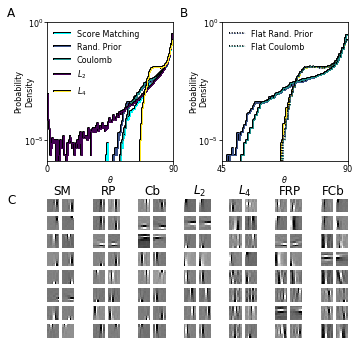

In [7]:
reload(plotting)
idxs1 = [6, 4, 2, 0, 1]
idxs2 = [1, 4, 5, 2, 3]
idxs3 = [6, 4, 2, 0, 1, 5, 3]
plotting.plot_figure4(ws[idxs1], [models[ii] for ii in idxs1],
                      ws[idxs2], [models[ii] for ii in idxs2],
                      ws[idxs3], [models[ii] for ii in idxs3],
                      save_path='/home/jesse/Downloads/figure5.pdf')

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(np.sqrt(1./params[0][2]))
ax1.set_title('data')

ax2.hist(np.sqrt(1./params_null[0][2]))
ax2.set_title('null')
plt.show()

In [31]:
fitter = gabor_fit.GaborFit()

In [28]:
n = 0

In [29]:
reload(plotting)
plotting.plot_bases(ws[n, 0])
wp = fitter.make_gabor(params[n][0][-1], 8, 8).T
wp = wp.reshape(wp.shape[0], -1)
plotting.plot_bases(wp)
plt.show()

NameError: name 'fitter' is not defined

In [34]:
reload(plotting)
plotting.plot_bases(ws_null[n])
wp = fitter.make_gabor(params_null[n][0][-1], 8, 8).T
wp = wp.reshape(wp.shape[0], -1)
plotting.plot_bases(wp)
plt.show()

# Score Matching

In [12]:
import os, h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image

from oc_ica.datasets import zca
from oc_ica.utils import tile_raster_images as tri
from oc_ica.models import sc, ica
from oc_ica.plotting import plot_bases
from oc_ica.sparsity_search import sparsity_search
from oc_ica.optimizers.ica_optimizers import sgd, adam, momentum
reload(sc)
reload(ica)

<module 'oc_ica.models.ica' from '/home/jesse/Development/oc_ica/oc_ica/models/ica.pyc'>

In [13]:
filename = os.path.join(os.environ['SCRATCH'],'data/vanhateren/images_curated.h5')
key = 'van_hateren_good'

with h5py.File(filename,'r') as f:
    images = f[key].value

In [32]:
patch_size = 8
n_mixtures = patch_size**2
total_samples = 100000
rng = np.random.RandomState(20170125)
patches = image.PatchExtractor(patch_size=(patch_size, patch_size),
                               max_patches=total_samples//images.shape[0],
                               random_state=rng).transform(images)
X = patches.reshape((patches.shape[0],n_mixtures)).T
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean
X_zca, d, u = zca(X)

In [33]:
OC = .75
n_sources = int(n_mixtures * float(OC))
model = ica.ICA(n_mixtures, n_sources, degeneracy='SM', lambd=0., rng=rng, norm_projection=True,
                #optimizer='sgd', learning_rule=adam, verbose=True)
                verbose=True)

Degeneracy control: SM
setup
transform


In [34]:
print(model.losses(X_zca))
model.fit(X_zca) #, n_epochs=1000)
print(model.losses(X_zca))

[array(-20.5378475189209, dtype=float32), array(-20.5378475189209, dtype=float32), array(0.0, dtype=float32), array(0.6628289222717285, dtype=float32)]
Loss: -23.120256424, Error: -23.120256424, Penalty: 0.0, MSE: 0.532486915588
Loss: -24.9580593109, Error: -24.9580593109, Penalty: 0.0, MSE: 0.423188567162
Loss: -25.6826133728, Error: -25.6826133728, Penalty: 0.0, MSE: 0.385157138109
Loss: -26.0141601562, Error: -26.0141601562, Penalty: 0.0, MSE: 0.368580043316
Loss: -26.2121334076, Error: -26.2121334076, Penalty: 0.0, MSE: 0.361532837152
Loss: -26.3592071533, Error: -26.3592071533, Penalty: 0.0, MSE: 0.367598444223
Loss: -26.5059890747, Error: -26.5059890747, Penalty: 0.0, MSE: 0.379490226507
Loss: -26.681842804, Error: -26.681842804, Penalty: 0.0, MSE: 0.407830774784
Loss: -26.8911457062, Error: -26.8911457062, Penalty: 0.0, MSE: 0.392673134804
Loss: -27.0122413635, Error: -27.0122413635, Penalty: 0.0, MSE: 0.392248541117
Loss: -27.240776062, Error: -27.240776062, Penalty: 0.0, MSE: 

In [35]:
sq = int(np.ceil(np.sqrt(n_sources)))
im = tri(model.components_, (patch_size, patch_size), (sq, sq), (2, 2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.show()

# SM ICA

In [11]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
x, y = np.meshgrid(x, y)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

z = np.log(np.cosh(x)) + np.log(np.cosh(y))
z = z-z.min()
z = z/z.max()
ax1.contour(x, y, z, aspect='equal', cmap='viridis')
ax1.set_title('log(cosh(s))')
ax1.set_xlabel('s1')
ax1.set_ylabel('s2')

z = (-1+1.5*np.tanh(x)**2) + (-1+.5*np.tanh(y)**2)
z = z-z.min()
z = z/z.max()
ax2.contour(x, y, z, aspect='equal', cmap='viridis')
ax2.set_title('-1+.5tanh(s1)^2')
ax2.set_xlabel('s1')
ax2.set_ylabel('s2')

plt.tight_layout()
plt.show()